<h1>From Michelson's interferometer to LIGO</h1>

This notebook requires Pyhton 2.7 or 3.4 (or higher), and Finesse (www.gwoptics.org/finesse) to run. See the provided document 'Simulation_preparation.pdf' for more information. 

At first we need to import some python modules and commands.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
from pykat import finesse
from pykat.commands import *
%matplotlib inline

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In the following we will construct models of interferometers, using the Finesse software, and compute the quantum-noise limited sensitivity. We start with a simple Michelson interferometer and slowly make our way towards the Advanced LIGO optical layout. After running this notebook you should a) be able to explain how the various elements of the optical layout help to reduce quantum noise, b) be able to run your own model of a modified Michelson interferometer, and c) plot the quantum noise limited sensitivity of the Advanced LIGO optical design. 

Preparing data containers for the various simultions we want to run:

In [2]:
data   = OrderedDict() # dictionary to store simultion output data
labels = {} # dictionary to store labels for the respective data
xrange = [5.0, 5000] # frequency range for the sensitivity plots
xsteps = 100 # number of steps on xaxis for the plots

<h2>Some basics</h2>

In [10]:
# creating the main Finesse object using pykat:
#kat = finesse.kat(tempdir=".",tempname="test1") # for debugging use this
kat = finesse.kat()
kat.verbose = False

# writing a Finesse input file
code = """
l l1 1 0 nin    # laser with P = 1W
s s1 1 nin nout # space, with free propoagation of 1m
pd output nout  # photo diode measuring light power
"""
kat.parse(code) # parsing the Finesse code into Pykat
print("input power is: {}".format(kat.l1.P.value)) # just checking the kat object

input power is: 1.0


In [11]:
kat.noxaxis=True   # just compute one data point for now
out = kat.run() # running the simulation
print("Measured output power is: {}".format(out["output"]))

Measured output power is: 1.0


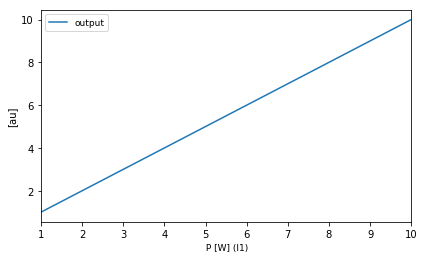

In [12]:
# or we sweep the input power
#kat.xaxis = xaxis("lin", [1, 10], kat.l1.P, 100)
kat.parseCommands("xaxis l1 P lin 1 10 100")
out = kat.run()
out.plot(); # and plot the result

<h3>The original (Michelson interferometer)</h3>

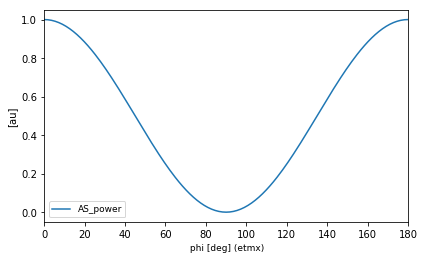

In [14]:
#kat = finesse.kat(tempdir=".",tempname="test1")
kat = finesse.kat()
kat.verbose = False
    
code_MI_0 = """
l l1 1 0 nin
s s1 0 nin nbsin
# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s armx $Larm n0x n3x
m1 etmx 5u 37.5u 0 n3x n4x

# Y-arm
s army $Larm n0y n3y
m1 etmy 5u 37.5u 0 n3y n4y

const Larm 3995
"""

code = """
pd AS_power nbsout
xaxis etmx phi lin 0 180 200
"""
kat.parse(code_MI_0)
kat.parse(code)
out=kat.run()
out.plot();

In order to prepare the model for computing the quantum limit sensitivity we will now do the following:
 - put etmx to phi=90, i.e. the dark fringe
 - add a DC offset to the dark fringe by slightly changing the tuning of etmx and etmy differentially, i.e. 
 	  - phi_etmx=89.999875 and phi_etmy=0.000125  
 - apply a differential signal to the two arms using the 'fsig' command, this allows to compute the signal response of the interferometer to a graviational wave

<h3>The signal reponse of the interferometer</h3>

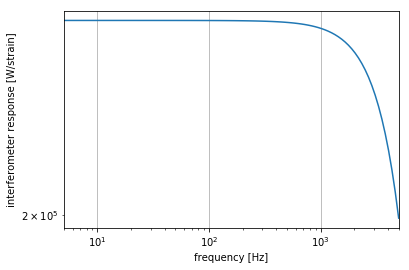

In [16]:
kat = finesse.kat()
kat.verbose = False
    
code_MI_1 = """
l l1 1 0 nin
s s1 0 nin nbsin
# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s armx $Larm n0x n3x
m1 etmx 5u 37.5u 89.999875 n3x n4x

# Y-arm
s army $Larm n0y n3y
m1 etmy 5u 37.5u 0.000125 n3y n4y

const Larm 3995
"""

code="""
# Differentially modulate the arm lengths
fsig darm  armx 1 0
fsig darm2 army 1 180

pd1 AS_power $fs nbsout
xaxis darm f log {0} {1} {2}
yaxis log abs
""".format(xrange[0],xrange[1], xsteps)

kat.parse(code_MI_1)
kat.parse(code)
out=kat.run()
fig = plt.figure()
plt.loglog(out.x, out.y)
plt.xlabel("frequency [Hz]")
plt.ylabel("interferometer response [W/strain]")
plt.xlim([np.min(out.x), np.max(out.x)])
plt.grid()



<h3>Plotting the sensitivity</h3>

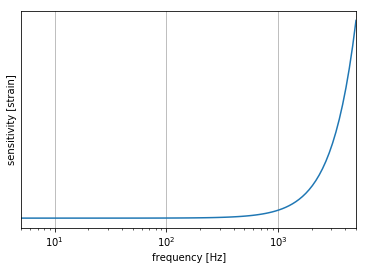

In [17]:
kat = finesse.kat()
kat.verbose = False
code_sens="""
# Differentially modulate the arm lengths
fsig darm  armx 1 0
fsig darm2 army 1 180

# Output the full quantum noise limited sensitivity
# calling it Noise to Signal Ratio (NSR)
qnoisedS NSR    1 $fs nbsout

xaxis darm f log {0} {1} {2}
yaxis log abs
""".format(xrange[0],xrange[1], xsteps)

kat.parse(code_MI_1)
kat.parse(code_sens)
out=kat.run()
fig = plt.figure()
plt.loglog(out.x, out.y)
plt.xlabel("frequency [Hz]")
plt.ylabel("sensitivity [strain]")
plt.xlim([np.min(out.x), np.max(out.x)])
plt.grid()

data["MI1"]=out
labels["MI1"]="MI shot noise (1W)"

To improve the shotnoise we increase the laser power to 125W.

So far we are only comptuing shot noise, but the mirrors are suspended and subject to radiation pressure noise. Let's add simple suspensions:

In [21]:
code_susp = """
# Force-to-position transfer function for longitudinal 
# motions of test masses
tf sus1 1 0 p $mech_fres $mech_Q
const mech_fres 1  # mech resonance freq
const mech_Q 1M    # suspension Q factor
"""
kat = finesse.kat()
kat.verbose = False
kat.parse(code_MI_1)
kat.l1.P=125.0 # increase power
kat.parse(code_sens)
kat.parse(code_susp)
code_mass="""
const Mtm 40 # mirror mass")
attr etmx mass $Mtm zmech sus1
attr etmy mass $Mtm zmech sus1
"""
kat.parse(code_mass)
out=kat.run()
data["MI2"]=out
labels["MI2"]="MI quantum noise"

<h2>Arm cavities</h2>

To increase the power in the arms further we introduce optical cavities.

In [22]:
code_FPMI = """
l l1 125.0 0 nin
s s1 0 nin nbsin
# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s ichx $lmichx n0x n1x
m1 itmx 0.014 37.5u 90 n1x n2x
s armx $Larm n2x n3x
m1 etmx 5u 37.5u 89.999875 n3x n4x
attr itmx mass $Mtm zmech sus1
attr etmx mass $Mtm zmech sus1

# Y-arm
s  ichy $lmichy n0y n1y
m1 itmy 0.014 37.5u 0 n1y n2y
s  army $Larm n2y n3y
m1 etmy 5u 37.5u 0.000125 n3y n4y
attr itmy mass $Mtm zmech sus1
attr etmy mass $Mtm zmech sus1

const Larm 3995
const lmichx 4.5
const lmichy 4.45
const Mtm 40 # mirror mass
"""

kat = finesse.kat()
kat.verbose = False
kat.parse(code_FPMI)
kat.parse(code_susp)
kat.parse(code_sens)
out=kat.run()
data["FPMI"]=out
labels["FPMI"]="FPMI"

<h2>Power recycling</h2>

In [24]:
code_FPMI = """
l l1 125.0 0 nin
s s1 0 nin nprc1
# Power recycling mirror
m1 prm 0.03 37.5u 90 nprc1 nprc2
s  prc $lprc nprc2 nbsin

# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s ichx $lmichx n0x n1x
m1 itmx 0.014 37.5u 90 n1x n2x
s armx $Larm n2x n3x
m1 etmx 5u 37.5u 89.999875 n3x n4x
attr itmx mass $Mtm zmech sus1
attr etmx mass $Mtm zmech sus1

# Y-arm
s  ichy $lmichy n0y n1y
m1 itmy 0.014 37.5u 0 n1y n2y
s  army $Larm n2y n3y
m1 etmy 5u 37.5u 0.000125 n3y n4y
attr itmy mass $Mtm zmech sus1
attr etmy mass $Mtm zmech sus1

const Larm 3995
const lmichx 4.5
const lmichy 4.45
const lprc   53
const Mtm 40 # mirror mass
"""

kat = finesse.kat()
kat.verbose = False
kat.parse(code_FPMI)
kat.parse(code_susp)
kat.parse(code_sens)
out=kat.run()
data["PRFPMI"]=out
labels["PRFPMI"]="PRFPMI"

<h2>Advanced LIGO</h2>

The following code is taken from the online example (on the Finesse home page) 'Advanced LIGO sensitivity'.

In [25]:
code_aLIGO = """
%------------------------------------------------------------------------
% Finesse input file to model a Michelson interferometer
% with power and signal recycling. The setup is based on
% the aLIGO reference design, DCC number M060056
% Daniel Brown 17.05.2014
%------------------------------------------------------------------------ 

l l1 $Pin 0 nin
s s1 0 nin nprc1
# Power recycling mirror
m1 prm $prmT 37.5u 90 nprc1 nprc2
s  prc $lprc nprc2 nbsin
# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s ichx $lmichx n0x n1x
m1 itmx $itmT 37.5u 90 n1x n2x
s armx $Larm n2x n3x
m1 etmx 5u 37.5u 89.999875 n3x n4x
attr itmx mass $Mtm zmech sus1
attr etmx mass $Mtm zmech sus1

# Y-arm
s  ichy $lmichy n0y n1y
m1 itmy $itmT 37.5u $michy_phi n1y n2y
s  army $Larm n2y n3y
m1 etmy 5u 37.5u 0.000125 n3y n4y
attr itmy mass $Mtm zmech sus1
attr etmy mass $Mtm zmech sus1

# Signal recycling mirror
s  src $lsrc nbsout nsrc1
m1 srm $srmT 37.5u $srm_phi nsrc1 nsrc2
#m srm 0 1 $srm_phi nsrc1 nsrc2

const michy_phi 0  
const Larm 3995
const itmT 0.014
const srmT 0.2
const prmT 0.03
const Pin  125 
const Mtm  40
const srm_phi -90 
const lmichx 4.5
const lmichy 4.45
const lprc   53
const lsrc   50.525 
"""

code_sensSR="""
# Differentially modulate the arm lengths
fsig darm  armx 1 0
fsig darm2 army 1 180

# Output the full quantum noise limited sensitivity
# calling it Noise to Signal Ratio (NSR)
qnoisedS NSR    1 $fs nsrc2

xaxis darm f log {0} {1} {2}
yaxis log abs
""".format(xrange[0],xrange[1], xsteps)

kat = finesse.kat()
kat.verbose = False    
kat.parse(code_aLIGO)
kat.parse(code_sensSR)
kat.parse(code_susp)
out=kat.run()
data["aLIGO"]=out
labels["aLIGO"]="Advanced LIGO design"

In [26]:
code_squeeze="""
# A squeezed source could be injected into the dark port
sq sq1 0 20 90 nsrc2
"""
kat = finesse.kat()
kat.verbose = False    
kat.parse(code_aLIGO)
kat.parse(code_sensSR)
kat.parse(code_susp)
kat.parse(code_squeeze)
out=kat.run()
data["squeezed"]=out
labels["squeezed"]="squeezed light"

Frequency dependent squeezing usinga a filter cavity:

In [28]:
L=16.0
c=3.0e8
fsr=c/(2*L)
print("FSR = {:g}".format(fsr))
FWHM=2*35.0
F=fsr/FWHM
print("required Finesse = {:g}".format(F))
# F =pi / (1-rr)
r = 1-math.pi/F
T=(1-r**2)
print("BS T= {:g}".format(T))
phi = 0.5*FWHM/fsr*180
print("detuning = {:g}".format(phi))

code_filter_cavity="""
s lFC0 1 nsrc2 nFCout
#bs1 IFC 61u 0 0 0 nFCin nFCout nIFC3 nIFC4
bs1 IFC {} 0 0 0 nFCin nFCout nIFC3 nIFC4
s lFC1 16 nIFC3 nEFC1
s lFC2 16 nEFC2 nIFC4
#bs1 EFC 0 0 -0.000882 0 nEFC1 nEFC2 dump dump
bs1 EFC 0 0 -{} 0 nEFC1 nEFC2 dump dump

# A squeezed source could be injected into the dark port
sq sq1 0 20 90 nFCin
""".format(T,phi)
kat = finesse.kat()
kat.verbose = False    
kat.parse(code_aLIGO)
kat.parse(code_sensSR)
kat.parse(code_susp)
kat.parse(code_filter_cavity)
out=kat.run()
data["squeezed_f"]=out
labels["squeezed_f"]="frequency dependent squeezing"

FSR = 9.375e+06
required Finesse = 133929
BS T= 4.69139e-05
detuning = 0.000672


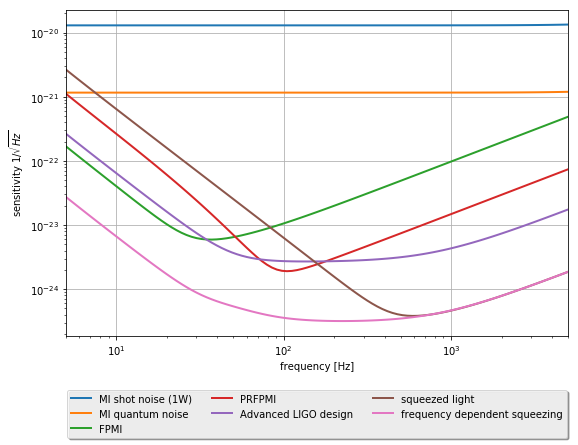

In [29]:
# Now plot all the above results together to compare:

fig = plt.figure()
ax = fig.add_subplot(111)

for key in data.keys():
    out = data[key]
    label = labels[key]
    ax.loglog(out.x,out.y, label=label)
plt.setp(ax.lines, linewidth=2)
plt.xlabel("frequency [Hz]")
plt.ylabel("sensitivity 1/$\sqrt{Hz}$")
plt.xlim([np.min(out.x), np.max(out.x)])
plt.grid()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height, box.width*1.5, box.height*1.5])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3);
#plt.legend(loc='best')

